In [1]:
import tensorflow as tf
tf.print(tf. __version__)

2.10.0


In [2]:

import keras
keras.__version__

'2.10.0'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, f1_score, precision_score, confusion_matrix

from keras import Sequential
from keras.layers import Dense, Input

from imblearn.over_sampling import SMOTE



pd.options.display.max_columns = None

In [4]:
def load() -> pd.DataFrame:
    df = pd.read_pickle("new_data.pickle")

    outsample = df[df["Date Announced"] > "2020-01-01"] # true out of sample, do not touch
    insample = df[df["Date Announced"] <= "2020-01-01"]

    return outsample, insample 

_, df = load()

In [5]:
df.head()

,Success,Date Announced,Date Effective,Date Withdrawn,Deal Number,Target Name,Target Primary Ticker Symbol,Target Industry Sector,Acquiror Name,Acquiror Primary Ticker Symbol,Acquiror Industry Sector,Exchange Ratio,Price Per Share,Acquiror's price per share,Acquiror Closing Price 1 Day After Ann Date ($),Acquiror Closing Price 60 Days After Ann Date ($),Acquiror Closing Price 90 Days After Ann Date ($),Acquiror Closing Price 180 Days After Ann Date ($),Target Share Price 1 Day Prior to Announcement ($),Target Closing Price 1 Day After Ann Date ($),Target Closing Price 60 Days After Ann Date ($),Target Closing Price 90 Days After Ann Date ($),Target Closing Price 180 Days After Ann Date ($),Premium 1 day prior to announce- ment date,Premium 1 week prior to announce- ment date,Premium 4 weeks prior to ann. date,S&P 500 Closing Price 1 Day Before Announcement,Poison Pill,% sought,Ratio of Offer Price to EPS,Ratio of Deal Value to Sales,Ratio of Deal Value to EBIT,Ratio of Deal Value to EBITDA,Ratio of Deal Value to Net Income,Ratio of Enterprise Value to Sales,Ratio of Enterprise Value to EBIT,Ratio of Enterprise Value to EBITDA,Ratio of Enterprise Value to Net Income,Equity Value/ Net Sales,Ratio of Equity Value to EBIT,Ratio of Equity Value at Announcement to EBITDA,Ratio of Equity Value to Net Income,Target Ebit 3-Year Growth Rate (%),Target Ebit 5-Year Growth Rate (%),EBIT Margin,Target EBITDA Three Year Growth Rate,Target EBITDA Five Year Growth Rate,EBITDA Margin,Target Net Assets Three Year Growth Rate,Target Net Assets Five Year Growth Rate,Target Net Sales 5-Year Growth Rate (%),Total Fee %,Target Fee %,Target Total Assets 5-Year Growth Rate (%),Target Total Lia. 5-Year Growth Rate (%),Common Equity Multiple,Value / Net Assets,EBIT / Return on Assets,EBITDA ROA,Enterprise Value / Net Assets,Enterprise Value / Pre-tax Inc,Enterprise Value / Tangible Book Value,Ratio of Offer Price to Book Value,Target Net Sales LTM ($mil),EBIT Last Twelve Months ($ Mil),Pre-tax Income Last Twelve Months ($ Mil),Net Income Last Twelve Months ($ Mil),Target Net Assets ($mil),Target Total Assets ($mil),Target EBITDA LTM ($mil),Target Book Value Per Share LTM (US$),Target Common Equity ($mil),Target Earnings Per Share LTM (US$),Value Based on Effective Date ($mil),Value Common at Eff. Date ($mil),Equity Value at Effective Date ($mil),Target Book Value/sh One Year Prior,Target Book Value/sh Two Years Prior,Target Book Value/sh Three Years Prior,Target Capital Expend. One Year Prior ($ mil),Target Capital Expend. Two Years Prior ($ mil),Target Capital Expend. Three Years Prior ($ mil),Target Cash & Mktbl. Securities One Year Prior ($ mil),Target Cash & Mktbl. Securities Two Years Prior ($ mil),Target Cash & Mktbl. Securities Three Years Prior ($ mil),Host Curr. Target Long Term Debt One Year Prior (mil),Host Curr. Target Long Term Debt Two Years Prior (mil),Host Curr. Target Long Term Debt Three Years Prior (mil),Target Long- Term Liab. 1-Year Prior ($ mil),Target Long- Term Liab. 2-Years Prior ($ mil),Target Long- Term Liab. 3-Years Prior ($ mil),Target Net Cash Fr. Investing One Year Prior,Target Net Cash Fr. Investing Two Years Prior,Target Net Cash Fr. Investing Three Years Prior,Target Net Cash fr. Financing One Year Prior,Target Net Cash fr. Financing Two Years Prior,Target Net Cash fr. Financing Three Years Prior,Target Straight Debt One Year Prior ($ mil),Target Straight Debt Two Years Prior ($ mil),Target Straight Debt Three Years Prior ($ mil)
3,0,2012-01-13,NaT,2012-05-04,2379612020,Georgia Gulf Corp,GGC,Chemicals and Allied Products,Westlake Chemical Corp,WLK,Chemicals and Allied Products,NaN,35.00,NaN,56.340,65.690,61.120,54.010,24.48,33.48,33.07,32.06,27.23,42.97,62.94,89.39,1295.50,Yes,95.2,21.0,0.372,8.9,5.067,21.199,0.533,12.718,7.260,30.376,0.372,8.877,5.067,21.200,118.999,-7.857,0.042,27.36,-8.503,0.073,13.90,25.53,0.52,NaN,NaN,-7.09,-12.94,2.453,2.5,0.082,0.144,3.515,32.078,7.521,2.452,3222.884,135.038,53.5,56.5,488.7,1640.4

## train model (sample)

In [6]:
cols_df = pd.read_csv("columns_to_select.csv")

minmax_cols = cols_df[cols_df["kind"] == "ratio"]["column_names"].values # columns that are already in terms of ratios, send direct to minmax/std scaler
scalar_cols = cols_df[cols_df["kind"] == "scalar"]["column_names"].values # columns that are in abs terms


all_cols = cols_df[cols_df["kind"].isin(["ratio","scalar"])]["column_names"].values


In [7]:
X = df[all_cols]
y = df["Success"]

train_len = int(len(df) * 0.75)
X.shape, y.shape

((1196, 71), (1196,))

In [8]:
X_train = X.iloc[:train_len,:]
y_train = y.iloc[:train_len]

X_test = X.iloc[train_len:,:]
y_test = y.iloc[train_len:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((897, 71), (897,), (299, 71), (299,))

In [9]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
imputer.fit(X_train)

X_train_imputed = pd.DataFrame(imputer.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), index=X_test.index, columns=X_test.columns)

X_train_imputed.isnull().any().any(), X_test_imputed.isnull().any().any(), X_train_imputed.shape, X_test_imputed.shape

(False, False, (897, 71), (299, 71))

#### Added SMOTE to increase the number of training data so that number of successful and failed mergers is the same.

In [10]:
#Oversampling the data
smote = SMOTE(random_state = 10)
X_train_imputed, y_train = smote.fit_resample(X_train_imputed, y_train)
X_train_imputed.shape, y_train.shape

((1566, 71), (1566,))

In [11]:
scaler = MinMaxScaler().fit(X_train_imputed)

X_train_norm = pd.DataFrame(scaler.transform(X_train_imputed), index=X_train_imputed.index, columns=X_train_imputed.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test_imputed), index=X_test_imputed.index, columns=X_test_imputed.columns)

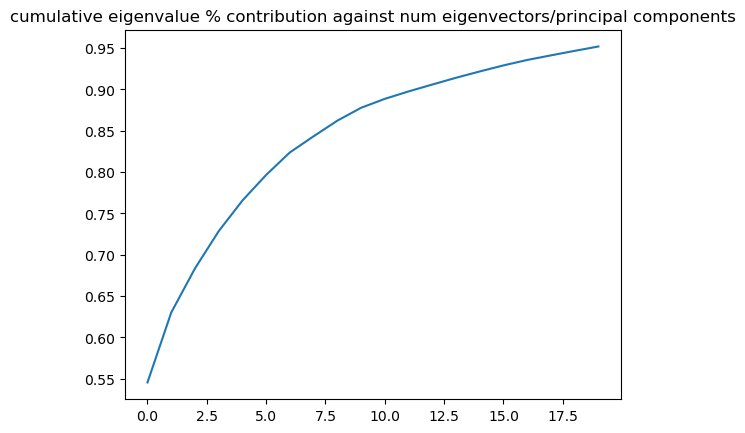

In [12]:
pca = PCA(n_components=20)
pca.fit(X_train_norm)

plt.plot(pca.explained_variance_ratio_.cumsum(), "-")
plt.title("cumulative eigenvalue % contribution against num eigenvectors/principal components")
plt.show()

In [13]:
X_train_pca = pd.DataFrame(pca.transform(X_train_norm), index=X_train_norm.index)
X_test_pca = pd.DataFrame(pca.transform(X_test_norm), index=X_test_norm.index)

X_train_pca.shape, X_test_pca.shape

((1566, 20), (299, 20))

In [14]:
## train dummy classifier (predict True for all events)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_pca, y_train)
yhat_dummy = dummy.predict(X_test_pca)
dummy.score(X_test_pca, y_test), confusion_matrix(y_test, yhat_dummy)

(0.09364548494983277,
 array([[ 28,   0],
        [271,   0]], dtype=int64))

In [15]:
# train classifier

clf = GradientBoostingClassifier()

clf.fit(X_train_pca, y_train)

yhat = clf.predict(X_test_pca)
clf.score(X_test_pca, y_test), precision_score(y_test, yhat), f1_score(y_test, yhat)

(0.7692307692307693, 0.9243697478991597, 0.8644400785854617)

In [16]:
confusion_matrix(y_test, yhat)

array([[ 10,  18],
       [ 51, 220]], dtype=int64)

#### Tested out with Decision Tree Classifier, Random Forest Classifier and Neural Network. Random Forest seems to work best with F1 score of 0.92. Neural network has second best F1 score of 0.906 followed by Decision Tree with F1 score of 0.875.

#### The range values are arbitrary and do not affect the results.

In [17]:
from sklearn.tree import DecisionTreeClassifier
for i in range(10, 83):
    
    dt = DecisionTreeClassifier(max_depth=16)
    dt.fit(X_train_pca, y_train)
    yhat_dt = dt.predict(X_test_pca)
    if (f1_score(y_test, yhat_dt)) > 0.87:
        print(i, dt.score(X_test_pca, y_test), precision_score(y_test, yhat_dt), f1_score(y_test, yhat_dt))
        print(confusion_matrix(y_test, yhat_dt))

15 0.7859531772575251 0.9330543933054394 0.8745098039215686
[[ 12  16]
 [ 48 223]]
17 0.7859531772575251 0.9294605809128631 0.8749999999999999
[[ 11  17]
 [ 47 224]]
23 0.782608695652174 0.9291666666666667 0.8727984344422701
[[ 11  17]
 [ 48 223]]
26 0.782608695652174 0.9256198347107438 0.8732943469785576
[[ 10  18]
 [ 47 224]]
29 0.782608695652174 0.9256198347107438 0.8732943469785576
[[ 10  18]
 [ 47 224]]
37 0.782608695652174 0.9221311475409836 0.8737864077669902
[[  9  19]
 [ 46 225]]
39 0.7792642140468228 0.9149797570850202 0.8725868725868726
[[  7  21]
 [ 45 226]]
42 0.7792642140468228 0.9253112033195021 0.87109375
[[ 10  18]
 [ 48 223]]
44 0.7792642140468228 0.9288702928870293 0.8705882352941177
[[ 11  17]
 [ 49 222]]
48 0.7759197324414716 0.9146341463414634 0.8704061895551258
[[  7  21]
 [ 46 225]]
56 0.7859531772575251 0.9259259259259259 0.8754863813229572
[[ 10  18]
 [ 46 225]]
58 0.7859531772575251 0.9330543933054394 0.8745098039215686
[[ 12  16]
 [ 48 223]]
62 0.78595317725

In [18]:
dt = DecisionTreeClassifier(max_depth=16)
dt.fit(X_train_pca, y_train)
yhat_dt = dt.predict(X_test_pca)
print(i, dt.score(X_test_pca, y_test), precision_score(y_test, yhat_dt), f1_score(y_test, yhat_dt))
confusion_matrix(y_test, yhat_dt)

82 0.7625418060200669 0.9201680672268907 0.8605108055009824


array([[  9,  19],
       [ 52, 219]], dtype=int64)

In [19]:
from sklearn.ensemble import RandomForestClassifier
for i in range(10, 42):
    rf = RandomForestClassifier(max_depth=20)
    rf.fit(X_train_pca, y_train)
    yhat_rf = rf.predict(X_test_pca)
    if (f1_score(y_test, yhat_rf)) > 0.915:
        print(i, rf.score(X_test_pca, y_test), precision_score(y_test, yhat_rf), f1_score(y_test, yhat_rf))
        print(confusion_matrix(y_test, yhat_rf))

13 0.8561872909698997 0.9191176470588235 0.9208103130755065
[[  6  22]
 [ 21 250]]
25 0.8528428093645485 0.9157509157509157 0.9191176470588235
[[  5  23]
 [ 21 250]]
27 0.8461538461538461 0.915129151291513 0.915129151291513
[[  5  23]
 [ 23 248]]
29 0.8494983277591973 0.9216417910447762 0.9165120593692022
[[  7  21]
 [ 24 247]]
30 0.8494983277591973 0.9185185185185185 0.9168207024029575
[[  6  22]
 [ 23 248]]
39 0.8528428093645485 0.9250936329588015 0.9182156133828996
[[  8  20]
 [ 24 247]]


#### Neural Network training with 1500 epochs

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam 

from tensorflow.keras.utils import plot_model

In [245]:
# Training Parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 100

# Network Parameters
n_input = 20 ## MNIST data input (img shape: 28*28 flattened to be 784)
n_hidden_1 = 400  # 1st layer number of neurons
n_hidden_2 = 400 # 2nd layer number of neurons

In [246]:
# building the model
Inp = Input(shape=(20,), name='Input')
x = Dense(n_hidden_1, activation='relu', name='Dense_01')(Inp)
x = Dense(n_hidden_2, activation='relu', name='Dense_02')(x)
x = Dense(200, activation='relu', name='Dense_03')(x)
outputs = Dense(1,activation='sigmoid', name='Outputs')(x)

model = Model(Inp, outputs, name='basic_model')

In [247]:
model.summary()

Model: "basic_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 20)]              0         
                                                                 
 Dense_01 (Dense)            (None, 400)               8400      
                                                                 
 Dense_02 (Dense)            (None, 400)               160400    
                                                                 
 Dense_03 (Dense)            (None, 200)               80200     
                                                                 
 Outputs (Dense)             (None, 1)                 201       
                                                                 
Total params: 249,201
Trainable params: 249,201
Non-trainable params: 0
_________________________________________________________________


In [248]:
# optimizer
opt = tf.keras.optimizers.Adam(learning_rate =1e-5, 
                               epsilon=1e-8)
                        

In [249]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
history = model.fit(X_train_pca, y_train, batch_size=32, validation_split=0.3, epochs=1500, verbose=1)


Epoch 1/1500
35/35 [==============================] - 1s 11ms/step - loss: 0.6874 - acc: 0.7144 - f1_m: 0.8334 - precision_m: 0.7231 - recall_m: 0.9910 - val_loss: 0.7108 - val_acc: 0.0021 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.6823 - acc: 0.7199 - f1_m: 0.8357 - precision_m: 0.7220 - recall_m: 1.0000 - val_loss: 0.7204 - val_acc: 0.0000e+00 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.6772 - acc: 0.7199 - f1_m: 0.8361 - precision_m: 0.7242 - recall_m: 1.0000 - val_loss: 0.7298 - val_acc: 0.0021 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.6719 - acc: 0.7199 - f1_m: 0.8337 - precision_m: 0.7188 - recall_m: 1.0000 - val_loss: 0.7410 - val_acc: 0.0021 - v

35/35 [==============================] - 0s 6ms/step - loss: 0.5578 - acc: 0.7336 - f1_m: 0.8400 - precision_m: 0.7367 - recall_m: 0.9843 - val_loss: 1.1504 - val_acc: 0.1362 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 32/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.5569 - acc: 0.7336 - f1_m: 0.8412 - precision_m: 0.7364 - recall_m: 0.9847 - val_loss: 1.1594 - val_acc: 0.1383 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 33/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.5562 - acc: 0.7372 - f1_m: 0.8365 - precision_m: 0.7323 - recall_m: 0.9852 - val_loss: 1.1641 - val_acc: 0.1447 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 34/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.5554 - acc: 0.7363 - f1_m: 0.8379 - precision_m: 0.7320 - recall_m: 0.9837 - val_loss: 1.1598 - val_acc: 0.1489 - val_f1_m: 0.0000

35/35 [==============================] - 0s 6ms/step - loss: 0.5395 - acc: 0.7454 - f1_m: 0.8475 - precision_m: 0.7499 - recall_m: 0.9828 - val_loss: 1.1419 - val_acc: 0.1723 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 62/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.5389 - acc: 0.7464 - f1_m: 0.8467 - precision_m: 0.7442 - recall_m: 0.9850 - val_loss: 1.1484 - val_acc: 0.1723 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 63/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.5383 - acc: 0.7445 - f1_m: 0.8442 - precision_m: 0.7442 - recall_m: 0.9817 - val_loss: 1.1456 - val_acc: 0.1723 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 64/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.5377 - acc: 0.7464 - f1_m: 0.8432 - precision_m: 0.7417 - recall_m: 0.9834 - val_loss: 1.1444 - val_acc: 0.1723 - val_f1_m: 0.0000

35/35 [==============================] - 0s 6ms/step - loss: 0.5222 - acc: 0.7555 - f1_m: 0.8490 - precision_m: 0.7483 - recall_m: 0.9862 - val_loss: 1.1157 - val_acc: 0.2128 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 92/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.5216 - acc: 0.7564 - f1_m: 0.8489 - precision_m: 0.7486 - recall_m: 0.9860 - val_loss: 1.1090 - val_acc: 0.2128 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 93/1500
35/35 [==============================] - 0s 7ms/step - loss: 0.5209 - acc: 0.7564 - f1_m: 0.8463 - precision_m: 0.7462 - recall_m: 0.9866 - val_loss: 1.1056 - val_acc: 0.2128 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 94/1500
35/35 [==============================] - 0s 7ms/step - loss: 0.5204 - acc: 0.7564 - f1_m: 0.8539 - precision_m: 0.7566 - recall_m: 0.9862 - val_loss: 1.1072 - val_acc: 0.2128 - val_f1_m: 0.0000

35/35 [==============================] - 0s 6ms/step - loss: 0.5039 - acc: 0.7619 - f1_m: 0.8559 - precision_m: 0.7580 - recall_m: 0.9862 - val_loss: 1.0796 - val_acc: 0.2298 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 122/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.5032 - acc: 0.7628 - f1_m: 0.8537 - precision_m: 0.7551 - recall_m: 0.9863 - val_loss: 1.0816 - val_acc: 0.2298 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 123/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.5027 - acc: 0.7628 - f1_m: 0.8535 - precision_m: 0.7566 - recall_m: 0.9868 - val_loss: 1.0811 - val_acc: 0.2319 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 124/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.5021 - acc: 0.7637 - f1_m: 0.8515 - precision_m: 0.7543 - recall_m: 0.9813 - val_loss: 1.0759 - val_acc: 0.2319 - val_f1_m: 0.0

35/35 [==============================] - 0s 6ms/step - loss: 0.4851 - acc: 0.7646 - f1_m: 0.8563 - precision_m: 0.7604 - recall_m: 0.9869 - val_loss: 1.0373 - val_acc: 0.2426 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 152/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.4844 - acc: 0.7655 - f1_m: 0.8523 - precision_m: 0.7545 - recall_m: 0.9858 - val_loss: 1.0465 - val_acc: 0.2404 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 153/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.4836 - acc: 0.7664 - f1_m: 0.8542 - precision_m: 0.7569 - recall_m: 0.9860 - val_loss: 1.0336 - val_acc: 0.2426 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 154/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.4831 - acc: 0.7664 - f1_m: 0.8569 - precision_m: 0.7616 - recall_m: 0.9866 - val_loss: 1.0304 - val_acc: 0.2447 - val_f1_m: 0.0

35/35 [==============================] - 0s 6ms/step - loss: 0.4662 - acc: 0.7719 - f1_m: 0.8614 - precision_m: 0.7692 - recall_m: 0.9866 - val_loss: 0.9997 - val_acc: 0.2553 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 182/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.4653 - acc: 0.7737 - f1_m: 0.8606 - precision_m: 0.7665 - recall_m: 0.9896 - val_loss: 1.0129 - val_acc: 0.2553 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 183/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.4647 - acc: 0.7728 - f1_m: 0.8622 - precision_m: 0.7685 - recall_m: 0.9874 - val_loss: 1.0088 - val_acc: 0.2553 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 184/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.4641 - acc: 0.7746 - f1_m: 0.8594 - precision_m: 0.7637 - recall_m: 0.9876 - val_loss: 1.0150 - val_acc: 0.2553 - val_f1_m: 0.0

35/35 [==============================] - 0s 6ms/step - loss: 0.4478 - acc: 0.7929 - f1_m: 0.8703 - precision_m: 0.7790 - recall_m: 0.9904 - val_loss: 0.9749 - val_acc: 0.2894 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 212/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.4471 - acc: 0.7929 - f1_m: 0.8709 - precision_m: 0.7815 - recall_m: 0.9900 - val_loss: 0.9733 - val_acc: 0.2872 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 213/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.4464 - acc: 0.7920 - f1_m: 0.8705 - precision_m: 0.7796 - recall_m: 0.9902 - val_loss: 0.9712 - val_acc: 0.2957 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 214/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.4458 - acc: 0.7938 - f1_m: 0.8665 - precision_m: 0.7743 - recall_m: 0.9893 - val_loss: 0.9671 - val_acc: 0.2979 - val_f1_m: 0.0

35/35 [==============================] - 0s 6ms/step - loss: 0.4294 - acc: 0.8066 - f1_m: 0.8793 - precision_m: 0.7941 - recall_m: 0.9904 - val_loss: 0.9340 - val_acc: 0.3383 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 242/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.4291 - acc: 0.8038 - f1_m: 0.8756 - precision_m: 0.7870 - recall_m: 0.9904 - val_loss: 0.9517 - val_acc: 0.3277 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 243/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.4282 - acc: 0.8075 - f1_m: 0.8789 - precision_m: 0.7939 - recall_m: 0.9904 - val_loss: 0.9288 - val_acc: 0.3468 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 244/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.4278 - acc: 0.8084 - f1_m: 0.8800 - precision_m: 0.7969 - recall_m: 0.9902 - val_loss: 0.9250 - val_acc: 0.3553 - val_f1_m: 0.0

35/35 [==============================] - 0s 6ms/step - loss: 0.4115 - acc: 0.8230 - f1_m: 0.8897 - precision_m: 0.8106 - recall_m: 0.9902 - val_loss: 0.9190 - val_acc: 0.3723 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 272/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.4111 - acc: 0.8193 - f1_m: 0.8875 - precision_m: 0.8070 - recall_m: 0.9902 - val_loss: 0.9198 - val_acc: 0.3745 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 273/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.4103 - acc: 0.8221 - f1_m: 0.8867 - precision_m: 0.8072 - recall_m: 0.9887 - val_loss: 0.9086 - val_acc: 0.3915 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 274/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.4099 - acc: 0.8248 - f1_m: 0.8821 - precision_m: 0.8021 - recall_m: 0.9886 - val_loss: 0.9026 - val_acc: 0.3957 - val_f1_m: 0.0

35/35 [==============================] - 0s 6ms/step - loss: 0.3940 - acc: 0.8385 - f1_m: 0.8956 - precision_m: 0.8260 - recall_m: 0.9832 - val_loss: 0.8679 - val_acc: 0.4277 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 302/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.3937 - acc: 0.8358 - f1_m: 0.8890 - precision_m: 0.8156 - recall_m: 0.9849 - val_loss: 0.8799 - val_acc: 0.4234 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 303/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.3929 - acc: 0.8440 - f1_m: 0.8984 - precision_m: 0.8322 - recall_m: 0.9795 - val_loss: 0.8505 - val_acc: 0.4383 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 304/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.3922 - acc: 0.8476 - f1_m: 0.9022 - precision_m: 0.8383 - recall_m: 0.9820 - val_loss: 0.8677 - val_acc: 0.4298 - val_f1_m: 0.0

35/35 [==============================] - 0s 6ms/step - loss: 0.3768 - acc: 0.8540 - f1_m: 0.9035 - precision_m: 0.8428 - recall_m: 0.9785 - val_loss: 0.8398 - val_acc: 0.4532 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 332/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.3763 - acc: 0.8549 - f1_m: 0.9041 - precision_m: 0.8482 - recall_m: 0.9734 - val_loss: 0.8278 - val_acc: 0.4660 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 333/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.3752 - acc: 0.8513 - f1_m: 0.8996 - precision_m: 0.8345 - recall_m: 0.9797 - val_loss: 0.8484 - val_acc: 0.4532 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 334/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.3749 - acc: 0.8522 - f1_m: 0.9028 - precision_m: 0.8405 - recall_m: 0.9784 - val_loss: 0.8379 - val_acc: 0.4574 - val_f1_m: 0.0

35/35 [==============================] - 0s 6ms/step - loss: 0.3593 - acc: 0.8613 - f1_m: 0.9076 - precision_m: 0.8535 - recall_m: 0.9745 - val_loss: 0.7989 - val_acc: 0.5043 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 362/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.3586 - acc: 0.8595 - f1_m: 0.9046 - precision_m: 0.8494 - recall_m: 0.9701 - val_loss: 0.7985 - val_acc: 0.5064 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 363/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.3580 - acc: 0.8613 - f1_m: 0.9090 - precision_m: 0.8590 - recall_m: 0.9722 - val_loss: 0.7982 - val_acc: 0.5064 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 364/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.3577 - acc: 0.8586 - f1_m: 0.9030 - precision_m: 0.8445 - recall_m: 0.9749 - val_loss: 0.8069 - val_acc: 0.5043 - val_f1_m: 0.0

35/35 [==============================] - 0s 6ms/step - loss: 0.3419 - acc: 0.8677 - f1_m: 0.9090 - precision_m: 0.8587 - recall_m: 0.9692 - val_loss: 0.7758 - val_acc: 0.5213 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 392/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.3411 - acc: 0.8695 - f1_m: 0.9146 - precision_m: 0.8652 - recall_m: 0.9741 - val_loss: 0.7714 - val_acc: 0.5234 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 393/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.3407 - acc: 0.8677 - f1_m: 0.9129 - precision_m: 0.8609 - recall_m: 0.9755 - val_loss: 0.7700 - val_acc: 0.5255 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 394/1500
35/35 [==============================] - 0s 6ms/step - loss: 0.3401 - acc: 0.8686 - f1_m: 0.9124 - precision_m: 0.8589 - recall_m: 0.9767 - val_loss: 0.7790 - val_acc: 0.5191 - val_f1_m: 0.0

35/35 [==============================] - 0s 10ms/step - loss: 0.3249 - acc: 0.8723 - f1_m: 0.9129 - precision_m: 0.8620 - recall_m: 0.9728 - val_loss: 0.7228 - val_acc: 0.5638 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 422/1500
35/35 [==============================] - 0s 10ms/step - loss: 0.3250 - acc: 0.8741 - f1_m: 0.9153 - precision_m: 0.8663 - recall_m: 0.9757 - val_loss: 0.7527 - val_acc: 0.5468 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 423/1500
35/35 [==============================] - 0s 10ms/step - loss: 0.3236 - acc: 0.8750 - f1_m: 0.9184 - precision_m: 0.8686 - recall_m: 0.9756 - val_loss: 0.7246 - val_acc: 0.5638 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 424/1500
35/35 [==============================] - 0s 10ms/step - loss: 0.3231 - acc: 0.8750 - f1_m: 0.9188 - precision_m: 0.8705 - recall_m: 0.9767 - val_loss: 0.7320 - val_acc: 0.5596 - val_f1_m:

35/35 [==============================] - 0s 10ms/step - loss: 0.3085 - acc: 0.8823 - f1_m: 0.9213 - precision_m: 0.8741 - recall_m: 0.9777 - val_loss: 0.7013 - val_acc: 0.5872 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 452/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.3081 - acc: 0.8814 - f1_m: 0.9196 - precision_m: 0.8726 - recall_m: 0.9759 - val_loss: 0.6976 - val_acc: 0.5872 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 453/1500
35/35 [==============================] - 0s 10ms/step - loss: 0.3071 - acc: 0.8814 - f1_m: 0.9213 - precision_m: 0.8736 - recall_m: 0.9777 - val_loss: 0.6978 - val_acc: 0.5872 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 454/1500
35/35 [==============================] - 0s 10ms/step - loss: 0.3066 - acc: 0.8823 - f1_m: 0.9191 - precision_m: 0.8720 - recall_m: 0.9752 - val_loss: 0.6983 - val_acc: 0.5894 - val_f1_m: 

35/35 [==============================] - 0s 7ms/step - loss: 0.2926 - acc: 0.8850 - f1_m: 0.9200 - precision_m: 0.8726 - recall_m: 0.9763 - val_loss: 0.6697 - val_acc: 0.6085 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 482/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.2919 - acc: 0.8841 - f1_m: 0.9238 - precision_m: 0.8808 - recall_m: 0.9738 - val_loss: 0.6586 - val_acc: 0.6213 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 483/1500
35/35 [==============================] - 0s 7ms/step - loss: 0.2913 - acc: 0.8850 - f1_m: 0.9232 - precision_m: 0.8776 - recall_m: 0.9771 - val_loss: 0.6718 - val_acc: 0.6106 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 484/1500
35/35 [==============================] - 0s 7ms/step - loss: 0.2907 - acc: 0.8859 - f1_m: 0.9182 - precision_m: 0.8726 - recall_m: 0.9725 - val_loss: 0.6571 - val_acc: 0.6213 - val_f1_m: 0.0

35/35 [==============================] - 0s 7ms/step - loss: 0.2776 - acc: 0.8905 - f1_m: 0.9242 - precision_m: 0.8812 - recall_m: 0.9748 - val_loss: 0.6322 - val_acc: 0.6404 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 512/1500
35/35 [==============================] - 0s 7ms/step - loss: 0.2770 - acc: 0.8969 - f1_m: 0.9298 - precision_m: 0.8927 - recall_m: 0.9742 - val_loss: 0.6174 - val_acc: 0.6596 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 513/1500
35/35 [==============================] - 0s 7ms/step - loss: 0.2763 - acc: 0.8978 - f1_m: 0.9303 - precision_m: 0.8942 - recall_m: 0.9725 - val_loss: 0.6294 - val_acc: 0.6426 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 514/1500
35/35 [==============================] - 0s 7ms/step - loss: 0.2758 - acc: 0.8960 - f1_m: 0.9300 - precision_m: 0.8932 - recall_m: 0.9737 - val_loss: 0.6298 - val_acc: 0.6447 - val_f1_m: 0.0

35/35 [==============================] - 0s 8ms/step - loss: 0.2631 - acc: 0.9033 - f1_m: 0.9329 - precision_m: 0.8959 - recall_m: 0.9762 - val_loss: 0.6090 - val_acc: 0.6702 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 542/1500
35/35 [==============================] - 0s 7ms/step - loss: 0.2630 - acc: 0.9078 - f1_m: 0.9371 - precision_m: 0.9118 - recall_m: 0.9670 - val_loss: 0.5922 - val_acc: 0.6872 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 543/1500
35/35 [==============================] - 0s 7ms/step - loss: 0.2620 - acc: 0.9042 - f1_m: 0.9364 - precision_m: 0.9028 - recall_m: 0.9747 - val_loss: 0.6175 - val_acc: 0.6638 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 544/1500
35/35 [==============================] - 0s 7ms/step - loss: 0.2620 - acc: 0.9033 - f1_m: 0.9354 - precision_m: 0.9017 - recall_m: 0.9748 - val_loss: 0.5972 - val_acc: 0.6830 - val_f1_m: 0.0

35/35 [==============================] - 0s 7ms/step - loss: 0.2497 - acc: 0.9124 - f1_m: 0.9373 - precision_m: 0.9052 - recall_m: 0.9762 - val_loss: 0.5915 - val_acc: 0.6957 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 572/1500
35/35 [==============================] - 0s 7ms/step - loss: 0.2492 - acc: 0.9124 - f1_m: 0.9354 - precision_m: 0.9048 - recall_m: 0.9705 - val_loss: 0.5702 - val_acc: 0.7064 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 573/1500
35/35 [==============================] - 0s 7ms/step - loss: 0.2490 - acc: 0.9179 - f1_m: 0.9442 - precision_m: 0.9193 - recall_m: 0.9731 - val_loss: 0.5683 - val_acc: 0.7064 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 574/1500
35/35 [==============================] - 0s 7ms/step - loss: 0.2484 - acc: 0.9161 - f1_m: 0.9388 - precision_m: 0.9078 - recall_m: 0.9759 - val_loss: 0.5939 - val_acc: 0.6915 - val_f1_m: 0.0

35/35 [==============================] - 0s 8ms/step - loss: 0.2372 - acc: 0.9215 - f1_m: 0.9469 - precision_m: 0.9259 - recall_m: 0.9707 - val_loss: 0.5505 - val_acc: 0.7234 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 602/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.2367 - acc: 0.9224 - f1_m: 0.9456 - precision_m: 0.9215 - recall_m: 0.9731 - val_loss: 0.5582 - val_acc: 0.7213 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 603/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.2363 - acc: 0.9234 - f1_m: 0.9488 - precision_m: 0.9289 - recall_m: 0.9716 - val_loss: 0.5614 - val_acc: 0.7191 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 604/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.2365 - acc: 0.9133 - f1_m: 0.9421 - precision_m: 0.9133 - recall_m: 0.9760 - val_loss: 0.5690 - val_acc: 0.7170 - val_f1_m: 0.0

35/35 [==============================] - 0s 7ms/step - loss: 0.2248 - acc: 0.9243 - f1_m: 0.9464 - precision_m: 0.9235 - recall_m: 0.9722 - val_loss: 0.5401 - val_acc: 0.7213 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 632/1500
35/35 [==============================] - 0s 7ms/step - loss: 0.2246 - acc: 0.9243 - f1_m: 0.9475 - precision_m: 0.9266 - recall_m: 0.9716 - val_loss: 0.5296 - val_acc: 0.7255 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 633/1500
35/35 [==============================] - 0s 7ms/step - loss: 0.2241 - acc: 0.9252 - f1_m: 0.9491 - precision_m: 0.9282 - recall_m: 0.9733 - val_loss: 0.5463 - val_acc: 0.7213 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 634/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.2237 - acc: 0.9234 - f1_m: 0.9461 - precision_m: 0.9221 - recall_m: 0.9738 - val_loss: 0.5357 - val_acc: 0.7234 - val_f1_m: 0.0

35/35 [==============================] - 0s 9ms/step - loss: 0.2134 - acc: 0.9270 - f1_m: 0.9503 - precision_m: 0.9302 - recall_m: 0.9740 - val_loss: 0.5142 - val_acc: 0.7574 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 662/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.2130 - acc: 0.9261 - f1_m: 0.9498 - precision_m: 0.9289 - recall_m: 0.9738 - val_loss: 0.5181 - val_acc: 0.7511 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 663/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.2125 - acc: 0.9261 - f1_m: 0.9487 - precision_m: 0.9265 - recall_m: 0.9741 - val_loss: 0.5102 - val_acc: 0.7574 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 664/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.2122 - acc: 0.9279 - f1_m: 0.9483 - precision_m: 0.9301 - recall_m: 0.9690 - val_loss: 0.5112 - val_acc: 0.7574 - val_f1_m: 0.0

35/35 [==============================] - 0s 8ms/step - loss: 0.2026 - acc: 0.9297 - f1_m: 0.9508 - precision_m: 0.9307 - recall_m: 0.9750 - val_loss: 0.5009 - val_acc: 0.7702 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 692/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.2026 - acc: 0.9334 - f1_m: 0.9533 - precision_m: 0.9368 - recall_m: 0.9727 - val_loss: 0.4892 - val_acc: 0.7766 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 693/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.2025 - acc: 0.9307 - f1_m: 0.9528 - precision_m: 0.9397 - recall_m: 0.9683 - val_loss: 0.5023 - val_acc: 0.7660 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 694/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.2017 - acc: 0.9297 - f1_m: 0.9509 - precision_m: 0.9311 - recall_m: 0.9737 - val_loss: 0.5083 - val_acc: 0.7617 - val_f1_m: 0.0

35/35 [==============================] - 0s 8ms/step - loss: 0.1925 - acc: 0.9389 - f1_m: 0.9583 - precision_m: 0.9451 - recall_m: 0.9735 - val_loss: 0.4676 - val_acc: 0.7915 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 722/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1923 - acc: 0.9361 - f1_m: 0.9512 - precision_m: 0.9332 - recall_m: 0.9736 - val_loss: 0.4836 - val_acc: 0.7830 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 723/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1920 - acc: 0.9370 - f1_m: 0.9543 - precision_m: 0.9397 - recall_m: 0.9716 - val_loss: 0.4690 - val_acc: 0.7915 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 724/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1914 - acc: 0.9361 - f1_m: 0.9541 - precision_m: 0.9358 - recall_m: 0.9749 - val_loss: 0.4821 - val_acc: 0.7851 - val_f1_m: 0.0

35/35 [==============================] - 0s 8ms/step - loss: 0.1836 - acc: 0.9407 - f1_m: 0.9589 - precision_m: 0.9519 - recall_m: 0.9674 - val_loss: 0.4629 - val_acc: 0.7936 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 752/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1826 - acc: 0.9407 - f1_m: 0.9575 - precision_m: 0.9430 - recall_m: 0.9737 - val_loss: 0.4597 - val_acc: 0.7979 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 753/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1823 - acc: 0.9407 - f1_m: 0.9563 - precision_m: 0.9428 - recall_m: 0.9727 - val_loss: 0.4590 - val_acc: 0.7979 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 754/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1819 - acc: 0.9416 - f1_m: 0.9604 - precision_m: 0.9505 - recall_m: 0.9733 - val_loss: 0.4456 - val_acc: 0.8043 - val_f1_m: 0.0

35/35 [==============================] - 0s 8ms/step - loss: 0.1742 - acc: 0.9434 - f1_m: 0.9607 - precision_m: 0.9517 - recall_m: 0.9717 - val_loss: 0.4333 - val_acc: 0.8064 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 782/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.1736 - acc: 0.9425 - f1_m: 0.9607 - precision_m: 0.9491 - recall_m: 0.9743 - val_loss: 0.4591 - val_acc: 0.8000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 783/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1733 - acc: 0.9453 - f1_m: 0.9611 - precision_m: 0.9501 - recall_m: 0.9741 - val_loss: 0.4435 - val_acc: 0.8043 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 784/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1729 - acc: 0.9453 - f1_m: 0.9623 - precision_m: 0.9535 - recall_m: 0.9734 - val_loss: 0.4601 - val_acc: 0.8000 - val_f1_m: 0.0

35/35 [==============================] - 0s 8ms/step - loss: 0.1649 - acc: 0.9471 - f1_m: 0.9620 - precision_m: 0.9548 - recall_m: 0.9717 - val_loss: 0.4343 - val_acc: 0.8106 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 812/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1646 - acc: 0.9480 - f1_m: 0.9648 - precision_m: 0.9517 - recall_m: 0.9794 - val_loss: 0.4300 - val_acc: 0.8106 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 813/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1643 - acc: 0.9453 - f1_m: 0.9607 - precision_m: 0.9526 - recall_m: 0.9707 - val_loss: 0.4362 - val_acc: 0.8106 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 814/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1642 - acc: 0.9453 - f1_m: 0.9626 - precision_m: 0.9488 - recall_m: 0.9782 - val_loss: 0.4468 - val_acc: 0.8021 - val_f1_m: 0.0

35/35 [==============================] - 0s 8ms/step - loss: 0.1566 - acc: 0.9489 - f1_m: 0.9628 - precision_m: 0.9521 - recall_m: 0.9764 - val_loss: 0.4265 - val_acc: 0.8170 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 842/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1565 - acc: 0.9489 - f1_m: 0.9646 - precision_m: 0.9560 - recall_m: 0.9748 - val_loss: 0.4134 - val_acc: 0.8255 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 843/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1561 - acc: 0.9507 - f1_m: 0.9664 - precision_m: 0.9577 - recall_m: 0.9763 - val_loss: 0.4370 - val_acc: 0.8106 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 844/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1560 - acc: 0.9498 - f1_m: 0.9642 - precision_m: 0.9507 - recall_m: 0.9791 - val_loss: 0.4198 - val_acc: 0.8277 - val_f1_m: 0.0

35/35 [==============================] - 0s 9ms/step - loss: 0.1489 - acc: 0.9544 - f1_m: 0.9667 - precision_m: 0.9557 - recall_m: 0.9795 - val_loss: 0.4045 - val_acc: 0.8277 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 872/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.1484 - acc: 0.9535 - f1_m: 0.9675 - precision_m: 0.9586 - recall_m: 0.9783 - val_loss: 0.4068 - val_acc: 0.8277 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 873/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.1483 - acc: 0.9535 - f1_m: 0.9683 - precision_m: 0.9591 - recall_m: 0.9793 - val_loss: 0.4130 - val_acc: 0.8234 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 874/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.1484 - acc: 0.9507 - f1_m: 0.9661 - precision_m: 0.9622 - recall_m: 0.9714 - val_loss: 0.4061 - val_acc: 0.8255 - val_f1_m: 0.0

35/35 [==============================] - 0s 8ms/step - loss: 0.1417 - acc: 0.9562 - f1_m: 0.9700 - precision_m: 0.9584 - recall_m: 0.9824 - val_loss: 0.4088 - val_acc: 0.8234 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 902/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1416 - acc: 0.9580 - f1_m: 0.9692 - precision_m: 0.9597 - recall_m: 0.9807 - val_loss: 0.3873 - val_acc: 0.8340 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 903/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1409 - acc: 0.9580 - f1_m: 0.9708 - precision_m: 0.9643 - recall_m: 0.9786 - val_loss: 0.4024 - val_acc: 0.8319 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 904/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.1408 - acc: 0.9562 - f1_m: 0.9694 - precision_m: 0.9588 - recall_m: 0.9813 - val_loss: 0.3934 - val_acc: 0.8319 - val_f1_m: 0.0

35/35 [==============================] - 0s 11ms/step - loss: 0.1345 - acc: 0.9580 - f1_m: 0.9702 - precision_m: 0.9634 - recall_m: 0.9783 - val_loss: 0.3834 - val_acc: 0.8426 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 932/1500
35/35 [==============================] - 0s 11ms/step - loss: 0.1342 - acc: 0.9608 - f1_m: 0.9730 - precision_m: 0.9672 - recall_m: 0.9799 - val_loss: 0.3971 - val_acc: 0.8383 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 933/1500
35/35 [==============================] - 0s 10ms/step - loss: 0.1344 - acc: 0.9599 - f1_m: 0.9681 - precision_m: 0.9592 - recall_m: 0.9785 - val_loss: 0.3897 - val_acc: 0.8404 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 934/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.1347 - acc: 0.9599 - f1_m: 0.9718 - precision_m: 0.9646 - recall_m: 0.9802 - val_loss: 0.3886 - val_acc: 0.8447 - val_f1_m: 

35/35 [==============================] - 0s 9ms/step - loss: 0.1281 - acc: 0.9617 - f1_m: 0.9691 - precision_m: 0.9579 - recall_m: 0.9828 - val_loss: 0.3952 - val_acc: 0.8383 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 962/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1279 - acc: 0.9626 - f1_m: 0.9732 - precision_m: 0.9669 - recall_m: 0.9810 - val_loss: 0.3870 - val_acc: 0.8426 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 963/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.1272 - acc: 0.9635 - f1_m: 0.9750 - precision_m: 0.9684 - recall_m: 0.9825 - val_loss: 0.3834 - val_acc: 0.8447 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 964/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.1270 - acc: 0.9635 - f1_m: 0.9744 - precision_m: 0.9662 - recall_m: 0.9834 - val_loss: 0.3854 - val_acc: 0.8447 - val_f1_m: 0.0

35/35 [==============================] - 0s 8ms/step - loss: 0.1213 - acc: 0.9644 - f1_m: 0.9753 - precision_m: 0.9710 - recall_m: 0.9801 - val_loss: 0.3902 - val_acc: 0.8426 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 992/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1214 - acc: 0.9644 - f1_m: 0.9738 - precision_m: 0.9637 - recall_m: 0.9853 - val_loss: 0.3629 - val_acc: 0.8574 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 993/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1209 - acc: 0.9653 - f1_m: 0.9766 - precision_m: 0.9700 - recall_m: 0.9846 - val_loss: 0.3702 - val_acc: 0.8532 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 994/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1208 - acc: 0.9644 - f1_m: 0.9758 - precision_m: 0.9671 - recall_m: 0.9854 - val_loss: 0.3565 - val_acc: 0.8660 - val_f1_m: 0.0

35/35 [==============================] - 0s 8ms/step - loss: 0.1150 - acc: 0.9662 - f1_m: 0.9767 - precision_m: 0.9706 - recall_m: 0.9841 - val_loss: 0.3863 - val_acc: 0.8447 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1022/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1149 - acc: 0.9662 - f1_m: 0.9767 - precision_m: 0.9689 - recall_m: 0.9853 - val_loss: 0.3806 - val_acc: 0.8447 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1023/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1156 - acc: 0.9662 - f1_m: 0.9771 - precision_m: 0.9699 - recall_m: 0.9856 - val_loss: 0.3922 - val_acc: 0.8362 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1024/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1144 - acc: 0.9653 - f1_m: 0.9726 - precision_m: 0.9702 - recall_m: 0.9769 - val_loss: 0.3593 - val_acc: 0.8617 - val_f1_m: 

35/35 [==============================] - 0s 8ms/step - loss: 0.1093 - acc: 0.9681 - f1_m: 0.9776 - precision_m: 0.9756 - recall_m: 0.9809 - val_loss: 0.3708 - val_acc: 0.8532 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1052/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1090 - acc: 0.9681 - f1_m: 0.9764 - precision_m: 0.9685 - recall_m: 0.9859 - val_loss: 0.3620 - val_acc: 0.8596 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1053/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1088 - acc: 0.9681 - f1_m: 0.9777 - precision_m: 0.9752 - recall_m: 0.9813 - val_loss: 0.3689 - val_acc: 0.8553 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1054/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.1088 - acc: 0.9672 - f1_m: 0.9775 - precision_m: 0.9708 - recall_m: 0.9853 - val_loss: 0.3630 - val_acc: 0.8596 - val_f1_m: 

35/35 [==============================] - 0s 9ms/step - loss: 0.1043 - acc: 0.9681 - f1_m: 0.9777 - precision_m: 0.9755 - recall_m: 0.9811 - val_loss: 0.3584 - val_acc: 0.8596 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1082/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1051 - acc: 0.9681 - f1_m: 0.9774 - precision_m: 0.9699 - recall_m: 0.9858 - val_loss: 0.3383 - val_acc: 0.8766 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1083/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1037 - acc: 0.9690 - f1_m: 0.9785 - precision_m: 0.9738 - recall_m: 0.9843 - val_loss: 0.3627 - val_acc: 0.8596 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1084/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.1038 - acc: 0.9653 - f1_m: 0.9759 - precision_m: 0.9738 - recall_m: 0.9791 - val_loss: 0.3860 - val_acc: 0.8574 - val_f1_m: 

35/35 [==============================] - 0s 8ms/step - loss: 0.0990 - acc: 0.9708 - f1_m: 0.9800 - precision_m: 0.9755 - recall_m: 0.9855 - val_loss: 0.3627 - val_acc: 0.8660 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1112/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0984 - acc: 0.9717 - f1_m: 0.9762 - precision_m: 0.9667 - recall_m: 0.9877 - val_loss: 0.3452 - val_acc: 0.8745 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1113/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0986 - acc: 0.9708 - f1_m: 0.9801 - precision_m: 0.9784 - recall_m: 0.9829 - val_loss: 0.3711 - val_acc: 0.8617 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1114/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0978 - acc: 0.9708 - f1_m: 0.9797 - precision_m: 0.9732 - recall_m: 0.9872 - val_loss: 0.3408 - val_acc: 0.8745 - val_f1_m: 

35/35 [==============================] - 0s 8ms/step - loss: 0.0940 - acc: 0.9699 - f1_m: 0.9790 - precision_m: 0.9723 - recall_m: 0.9868 - val_loss: 0.3263 - val_acc: 0.8851 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1142/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0933 - acc: 0.9754 - f1_m: 0.9828 - precision_m: 0.9795 - recall_m: 0.9868 - val_loss: 0.3683 - val_acc: 0.8681 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1143/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0929 - acc: 0.9717 - f1_m: 0.9801 - precision_m: 0.9732 - recall_m: 0.9878 - val_loss: 0.3470 - val_acc: 0.8745 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1144/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0928 - acc: 0.9699 - f1_m: 0.9788 - precision_m: 0.9778 - recall_m: 0.9809 - val_loss: 0.3542 - val_acc: 0.8681 - val_f1_m: 

35/35 [==============================] - 0s 8ms/step - loss: 0.0887 - acc: 0.9717 - f1_m: 0.9786 - precision_m: 0.9735 - recall_m: 0.9848 - val_loss: 0.3487 - val_acc: 0.8723 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1172/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0885 - acc: 0.9726 - f1_m: 0.9808 - precision_m: 0.9785 - recall_m: 0.9840 - val_loss: 0.3582 - val_acc: 0.8681 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1173/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0898 - acc: 0.9717 - f1_m: 0.9779 - precision_m: 0.9701 - recall_m: 0.9872 - val_loss: 0.3288 - val_acc: 0.8809 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1174/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0881 - acc: 0.9735 - f1_m: 0.9809 - precision_m: 0.9802 - recall_m: 0.9823 - val_loss: 0.3567 - val_acc: 0.8702 - val_f1_m: 

35/35 [==============================] - 0s 9ms/step - loss: 0.0843 - acc: 0.9726 - f1_m: 0.9794 - precision_m: 0.9750 - recall_m: 0.9853 - val_loss: 0.3516 - val_acc: 0.8723 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1202/1500
35/35 [==============================] - 0s 10ms/step - loss: 0.0834 - acc: 0.9745 - f1_m: 0.9826 - precision_m: 0.9804 - recall_m: 0.9854 - val_loss: 0.3452 - val_acc: 0.8787 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1203/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0836 - acc: 0.9726 - f1_m: 0.9775 - precision_m: 0.9781 - recall_m: 0.9788 - val_loss: 0.3287 - val_acc: 0.8830 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1204/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0839 - acc: 0.9726 - f1_m: 0.9813 - precision_m: 0.9759 - recall_m: 0.9876 - val_loss: 0.3279 - val_acc: 0.8830 - val_f1_m:

35/35 [==============================] - 0s 8ms/step - loss: 0.0793 - acc: 0.9772 - f1_m: 0.9843 - precision_m: 0.9829 - recall_m: 0.9865 - val_loss: 0.3239 - val_acc: 0.8830 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1232/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0790 - acc: 0.9745 - f1_m: 0.9822 - precision_m: 0.9779 - recall_m: 0.9870 - val_loss: 0.3326 - val_acc: 0.8809 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1233/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0790 - acc: 0.9745 - f1_m: 0.9825 - precision_m: 0.9791 - recall_m: 0.9865 - val_loss: 0.3584 - val_acc: 0.8702 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1234/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0785 - acc: 0.9735 - f1_m: 0.9816 - precision_m: 0.9764 - recall_m: 0.9874 - val_loss: 0.3083 - val_acc: 0.8957 - val_f1_m: 

35/35 [==============================] - 0s 9ms/step - loss: 0.0754 - acc: 0.9763 - f1_m: 0.9835 - precision_m: 0.9774 - recall_m: 0.9902 - val_loss: 0.3376 - val_acc: 0.8766 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1262/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0758 - acc: 0.9745 - f1_m: 0.9825 - precision_m: 0.9832 - recall_m: 0.9826 - val_loss: 0.3527 - val_acc: 0.8723 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1263/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0745 - acc: 0.9754 - f1_m: 0.9829 - precision_m: 0.9780 - recall_m: 0.9888 - val_loss: 0.3155 - val_acc: 0.8936 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1264/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0752 - acc: 0.9745 - f1_m: 0.9802 - precision_m: 0.9749 - recall_m: 0.9870 - val_loss: 0.3171 - val_acc: 0.8936 - val_f1_m: 

35/35 [==============================] - 0s 8ms/step - loss: 0.0709 - acc: 0.9781 - f1_m: 0.9807 - precision_m: 0.9750 - recall_m: 0.9883 - val_loss: 0.3221 - val_acc: 0.8915 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1292/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0708 - acc: 0.9799 - f1_m: 0.9861 - precision_m: 0.9850 - recall_m: 0.9877 - val_loss: 0.3374 - val_acc: 0.8787 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1293/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0706 - acc: 0.9763 - f1_m: 0.9837 - precision_m: 0.9797 - recall_m: 0.9885 - val_loss: 0.3302 - val_acc: 0.8830 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1294/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0703 - acc: 0.9781 - f1_m: 0.9846 - precision_m: 0.9814 - recall_m: 0.9884 - val_loss: 0.3454 - val_acc: 0.8766 - val_f1_m: 

35/35 [==============================] - 0s 8ms/step - loss: 0.0674 - acc: 0.9799 - f1_m: 0.9862 - precision_m: 0.9840 - recall_m: 0.9890 - val_loss: 0.3442 - val_acc: 0.8787 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1322/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0672 - acc: 0.9799 - f1_m: 0.9863 - precision_m: 0.9831 - recall_m: 0.9900 - val_loss: 0.3237 - val_acc: 0.8872 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1323/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0667 - acc: 0.9799 - f1_m: 0.9860 - precision_m: 0.9837 - recall_m: 0.9889 - val_loss: 0.3400 - val_acc: 0.8787 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1324/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0665 - acc: 0.9781 - f1_m: 0.9851 - precision_m: 0.9820 - recall_m: 0.9890 - val_loss: 0.3508 - val_acc: 0.8745 - val_f1_m: 

35/35 [==============================] - 0s 9ms/step - loss: 0.0632 - acc: 0.9808 - f1_m: 0.9867 - precision_m: 0.9852 - recall_m: 0.9887 - val_loss: 0.3512 - val_acc: 0.8745 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1352/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0631 - acc: 0.9790 - f1_m: 0.9853 - precision_m: 0.9827 - recall_m: 0.9886 - val_loss: 0.3386 - val_acc: 0.8787 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1353/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0626 - acc: 0.9808 - f1_m: 0.9867 - precision_m: 0.9844 - recall_m: 0.9897 - val_loss: 0.3273 - val_acc: 0.8872 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1354/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0633 - acc: 0.9827 - f1_m: 0.9880 - precision_m: 0.9874 - recall_m: 0.9892 - val_loss: 0.3776 - val_acc: 0.8532 - val_f1_m: 

35/35 [==============================] - 0s 10ms/step - loss: 0.0594 - acc: 0.9836 - f1_m: 0.9885 - precision_m: 0.9886 - recall_m: 0.9888 - val_loss: 0.3429 - val_acc: 0.8787 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1382/1500
35/35 [==============================] - 0s 8ms/step - loss: 0.0599 - acc: 0.9808 - f1_m: 0.9866 - precision_m: 0.9836 - recall_m: 0.9901 - val_loss: 0.3378 - val_acc: 0.8809 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1383/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0594 - acc: 0.9827 - f1_m: 0.9881 - precision_m: 0.9875 - recall_m: 0.9891 - val_loss: 0.3342 - val_acc: 0.8787 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1384/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0589 - acc: 0.9818 - f1_m: 0.9859 - precision_m: 0.9848 - recall_m: 0.9878 - val_loss: 0.3350 - val_acc: 0.8830 - val_f1_m:

35/35 [==============================] - 0s 10ms/step - loss: 0.0561 - acc: 0.9827 - f1_m: 0.9873 - precision_m: 0.9863 - recall_m: 0.9890 - val_loss: 0.3241 - val_acc: 0.8915 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1412/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0561 - acc: 0.9818 - f1_m: 0.9873 - precision_m: 0.9852 - recall_m: 0.9899 - val_loss: 0.3212 - val_acc: 0.8936 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1413/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0560 - acc: 0.9845 - f1_m: 0.9893 - precision_m: 0.9889 - recall_m: 0.9904 - val_loss: 0.3219 - val_acc: 0.8915 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1414/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0557 - acc: 0.9836 - f1_m: 0.9883 - precision_m: 0.9888 - recall_m: 0.9884 - val_loss: 0.3393 - val_acc: 0.8809 - val_f1_m:

35/35 [==============================] - 0s 10ms/step - loss: 0.0528 - acc: 0.9854 - f1_m: 0.9894 - precision_m: 0.9906 - recall_m: 0.9887 - val_loss: 0.3431 - val_acc: 0.8787 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1442/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0529 - acc: 0.9836 - f1_m: 0.9888 - precision_m: 0.9881 - recall_m: 0.9898 - val_loss: 0.3433 - val_acc: 0.8830 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1443/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0524 - acc: 0.9836 - f1_m: 0.9887 - precision_m: 0.9876 - recall_m: 0.9902 - val_loss: 0.3374 - val_acc: 0.8830 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1444/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0527 - acc: 0.9845 - f1_m: 0.9896 - precision_m: 0.9889 - recall_m: 0.9907 - val_loss: 0.3446 - val_acc: 0.8787 - val_f1_m:

35/35 [==============================] - 0s 9ms/step - loss: 0.0502 - acc: 0.9845 - f1_m: 0.9874 - precision_m: 0.9864 - recall_m: 0.9895 - val_loss: 0.3078 - val_acc: 0.9064 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1472/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0503 - acc: 0.9836 - f1_m: 0.9886 - precision_m: 0.9882 - recall_m: 0.9895 - val_loss: 0.3139 - val_acc: 0.9043 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1473/1500
35/35 [==============================] - 0s 9ms/step - loss: 0.0497 - acc: 0.9854 - f1_m: 0.9897 - precision_m: 0.9915 - recall_m: 0.9884 - val_loss: 0.3213 - val_acc: 0.8979 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 1474/1500
35/35 [==============================] - 0s 10ms/step - loss: 0.0495 - acc: 0.9836 - f1_m: 0.9881 - precision_m: 0.9880 - recall_m: 0.9886 - val_loss: 0.3207 - val_acc: 0.8979 - val_f1_m:

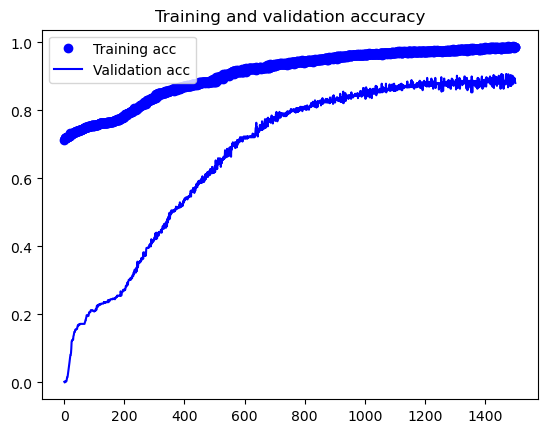

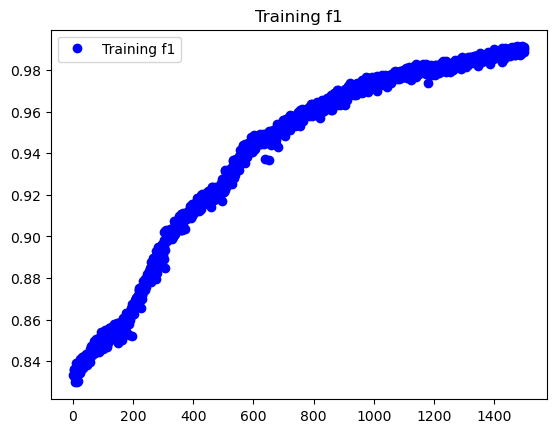

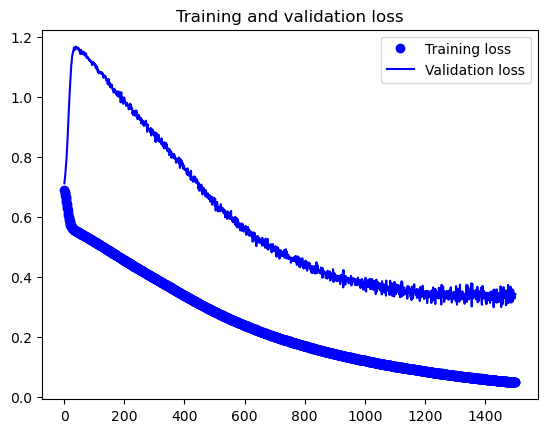

In [250]:
acc = history.history['acc']
val_acc = history.history['val_acc']
f1 = history.history['f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, f1, 'bo', label='Training f1')
plt.title('Training f1')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [251]:

# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test_pca, y_test, verbose=0)
print(loss, accuracy, f1_score, precision, recall)

3.4898996353149414 0.8361204266548157 0.9056779742240906 0.9215222597122192 0.8919844627380371


In [252]:
yhat_tf = model.predict(X_test_pca)
print(confusion_matrix(y_test, tf.where(yhat_tf < 0.5, 0., 1.)))

10/10 [==============================] - 0s 3ms/step
[[  8  20]
 [ 29 242]]


#### Testing with 5 epochs of training

In [257]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
history = model.fit(X_train_pca, y_train, batch_size=32, validation_split=0.3, epochs=5, verbose=1)


Epoch 1/5
35/35 [==============================] - 1s 15ms/step - loss: 0.0463 - acc: 0.9872 - f1_m: 0.9911 - precision_m: 0.9938 - recall_m: 0.9888 - val_loss: 0.3553 - val_acc: 0.8745 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/5
35/35 [==============================] - 0s 10ms/step - loss: 0.0463 - acc: 0.9881 - f1_m: 0.9914 - precision_m: 0.9910 - recall_m: 0.9923 - val_loss: 0.3131 - val_acc: 0.9064 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/5
35/35 [==============================] - 0s 10ms/step - loss: 0.0461 - acc: 0.9845 - f1_m: 0.9892 - precision_m: 0.9904 - recall_m: 0.9885 - val_loss: 0.3385 - val_acc: 0.8894 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/5
35/35 [==============================] - 0s 10ms/step - loss: 0.0460 - acc: 0.9881 - f1_m: 0.9919 - precision_m: 0.9937 - recall_m: 0.9903 - val_loss: 0.3585 - val_acc: 0.8787 - val_f1_m: 0.00

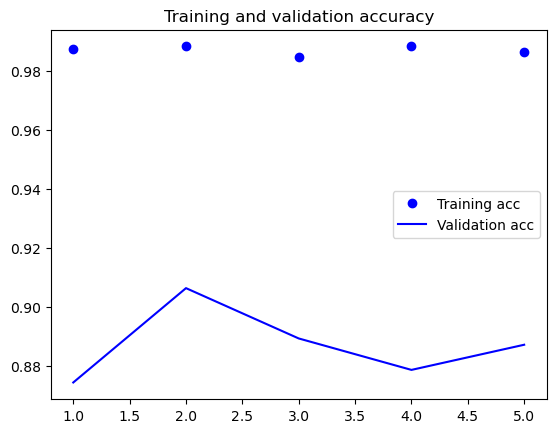

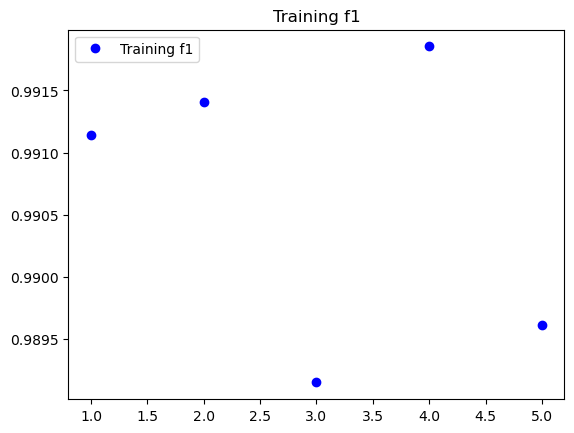

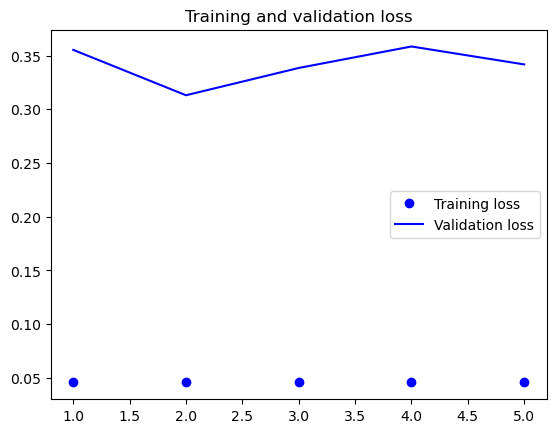

In [258]:
acc = history.history['acc']
val_acc = history.history['val_acc']
f1 = history.history['f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, f1, 'bo', label='Training f1')
plt.title('Training f1')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [259]:

# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test_pca, y_test, verbose=0)
print(loss, accuracy, f1_score, precision, recall)

3.523102283477783 0.8361204266548157 0.9056779742240906 0.9215222597122192 0.8919844627380371


In [260]:
yhat_tf = model.predict(X_test_pca)
print(confusion_matrix(y_test, tf.where(yhat_tf < 0.5, 0., 1.)))

10/10 [==============================] - 0s 4ms/step
[[  8  20]
 [ 29 242]]
